# **Introduction**

This notebook is for implementing a Deep Q-Network (DQN) algorithm for the ``cartpole`` environment offered through Gymnasium. Gymnasium is an open source Python library for developing and comparing reinforcement learning algorithms, through the use of a standardized API.

# **Import Packages**

This section imports the necessary packages:

In [90]:
# import these packages:
import gymnasium as gym
from wrappers.swingup_wrapper import SwingUpWrapper
import numpy as np
import random
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

from collections import deque

# **Environment Setup**

This section sets up the environment and defines the relevant functions needed for this implementation.

##### Function for making Keras models:

In [91]:
# function for making a keras model:
def make_model(layers, neurons, rate, norm, drop, input_shape, output_shape, loss_function):
    # instantiate model:
    model = keras.Sequential()

    # add hidden layers:
    for i in range(layers):
        if i == 0:
            model.add(Input(shape = (input_shape, )))
            model.add(Dense(neurons, activation = 'relu', name = f'hidden_layer_{i+1}'))
        else:
            model.add(Dense(neurons, activation = 'relu', name = f'hidden_layer_{i+1}'))

        if norm == True:
            model.add(BatchNormalization(name = f'batch_norm_layer_{i+1}'))

        if drop == True:
            model.add(Dropout(0.2, name = f'dropout_layer_{i+1}'))
    
    # add output layer:
    model.add(Dense(output_shape, activation = 'linear', name = 'output_layer'))

    # compile the model:
    model.compile(optimizer = Adam(learning_rate = rate),
                  loss = loss_function)
    
    return model 

##### DQN class:

In [92]:
# DQN agent class:
class DQN_Agent:
    ####################### INITIALIZATION #######################
    # constructor:
    def __init__(self, 
        env: gym.Env, 
        gamma: float, 
        lr: float,
        epsilon: float,
        epsilon_min: float,
        epsilon_decay: float,
        batch_size: int,
        buffer_size: int,
        target_update_freq: int, 
        train_freq: int,
        layers = int,
        neurons = int, 
        seed = int):
        """ 
        this is the constructor for the agent. this agent uses a DQN to learn an optimal policy, through the use of approximator neural network 
        to approximate action-value Q, and a target network to generate a Q-target used in the updating of Q(s,a). this is done to prevent updates
        to the network weights from changing the target, meaning that we aren't bootstrapping towards a changing target. this helps to stabilize the learning.

        env:                    a gymnasium environment
        gamma:                  a float value indicating the discount factor γ
        lr:                     a float value indicating the learning rate α
        epsilon:                a float value indicating the action-selection probability ε
        epsilon_min:            a float value indicating the minimum ε value
        epsilon_decay:          a float value indicating the decay rate of ε
        batch_size:             an int representing the batch size sampled from the experience
        buffer_size:            an int representing the size of the memory buffer
        target_update_freq:     an int representing how frequently the target network weights should be updated
        train_freq:             an int representing how frequently training should occur
        layers:                 an int representing the number of layers in each network
        neurons:                an int representing the number of neurons in each network
        seed:                   an int representing the random seed of the environment, for reproducability

        nS:         an int representing the number of states observed, each of which is continuous
        nA:         an int representing the number of discrete actions that can be taken

        q_network:                  a Keras sequential neural network representing the actual function approximator
        target_network:             a Keras sequential neural network representing responsible for generating Q-targets
        experience:                 an empty deque used to hold the experience history of the agent, limited to buffer_size


        """
        # object parameters:
        self.env = env
        self.gamma = gamma
        self.lr = lr
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # get the environment dimensions:
        self.nS = self.env.observation_space.shape[0]
        self.nA = self.env.action_space.n

        # experience history and mini-batch size:
        self.replay_buffer = deque(maxlen = buffer_size)
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.step_counter = 0

        # initialize networks:
        self.q_network = make_model(layers = layers, neurons = neurons, rate = lr,
                                                norm = True, drop = True,
                                                input_shape = self.nS, output_shape = self.nA,
                                                loss_function = 'mse')
        self.target_network = keras.models.clone_model(self.q_network)
        self.target_network.set_weights(self.q_network.get_weights())

        # set target update and training frequencies:
        self.target_update_freq = target_update_freq
        self.train_freq = train_freq

        # set the seed:
        self.seed = seed

    ####################### TRAINING #######################
    # define a decorated function to infer Q's from batched states (this is the implicit policy):
    @tf.function
    def get_qs(self, obs_batch):
        return self.q_network(obs_batch)
    
    # define a decorated function to perform the DQN training step for updating Q network weights:
    @tf.function
    def training_step(self, states, actions, rewards, next_states, dones):
        # track auto differentiation:
        with tf.GradientTape() as tape:
            # 1) do a forward pass to get Q values:
            # this is all the Q values from every state:
            q_all = self.q_network(states)

            # find relevant index of actions that will be selected:
            index = tf.stack([tf.range(tf.shape(actions)[0]), actions], axis = 1)

            # gather up the Q values that correspond to actions actually taken:
            q_selected = tf.gather_nd(q_all, index)

            # 2) compute TD-targets:
            # TD-target is computed with S', A', w-:
            q_next = self.target_network(next_states)

            # get the Q value corresponding to the max over the actions:
            max_q_next = tf.reduce_max(q_next, axis = 1)

            # compute actual TD-targets:
            targets = tf.stop_gradient(rewards + (1 - dones) * self.gamma * max_q_next)

            # 3) MSE loss between the Qs that correspond to taken actions and the TD-target:
            loss = tf.reduce_mean(tf.square(targets - q_selected))
        
        # 4) backpropagate and update the weights:
        grads = tape.gradient(loss, self.q_network.trainable_variables)
        self.q_network.optimizer.apply_gradients(zip(grads, self.q_network.trainable_variables))

    # training function:
    def training(self, training_length):

        reward_history = np.zeros(training_length)

        # for every episode:
        for episode in tqdm(range(training_length), colour = "#33FF00", ncols = 100, desc = "training progress"):
            # reset environment:
            obs, _ = self.env.reset()
            episode_reward = 0
            done = False

            # while false:
            while not done:
                # ε-greedy policy:
                if np.random.random() < self.epsilon:
                    action = self.env.action_space.sample()
                else:
                    obs_batch = tf.expand_dims(tf.convert_to_tensor(obs, dtype = tf.float32), 0)
                    qs = self.get_qs(obs_batch)
                    action = tf.argmax(qs[0]).numpy()

                # interact with the environment:
                next_obs, reward, term, trunc, _ = self.env.step(action)
                done = term or trunc
                self.replay_buffer.append((obs, action, reward, next_obs, done))
                obs = next_obs
                episode_reward += reward
                self.step_counter += 1

                # sample a batch of experience:
                if len(self.replay_buffer) >= self.batch_size and self.step_counter % self.train_freq == 0:
                    # get a batch:
                    batch = random.sample(self.replay_buffer, self.batch_size)

                    # unpack the batch:
                    states, actions, rewards, next_states, dones = zip(*batch)

                    # convert to tensors:
                    states = tf.convert_to_tensor(states, dtype = tf.float32)
                    actions = tf.convert_to_tensor(actions, dtype = tf.int32)
                    rewards = tf.convert_to_tensor(rewards, dtype = tf.float32)
                    next_states = tf.convert_to_tensor(next_states, dtype = tf.float32)
                    dones = tf.convert_to_tensor(dones, dtype = tf.float32)

                    # single graph call:
                    self.training_step(states, actions, rewards, next_states, dones)

                    # update target network periodically:
                    if self.step_counter % self.target_update_freq == 0:
                        self.target_network.set_weights(self.q_network.get_weights())

            # decay epsilon:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            # advance reward history:
            reward_history[episode] = episode_reward
        
        return reward_history

# **Using the Environment**

This section utilizes the above DQN to create an environment and train an agent.

##### Specify hyperparameters:

In [ ]:
# agent hyperparameters:
lr = 1e-4                   # learning rate α
gamma = 0.999               # discount factor γ
epsilon = 1.0               # starting value of ε
epsilon_min = 0.05          # final value of ε
epsilon_decay = 0.99        # decay rate of ε

buffer_size = 8000          # size of the replay buffer
batch_size = 64             # amount sampled from buffer
target_update_freq = 100    # number of elapsed steps before target network is updated
train_freq = 1              # frequency at which the training occurs

training_length = 2000      # how many episodes to train the network for
warmup_length = 8000        # how many steps of experience to populate the replay buffer

neurons = 128               # how many neurons to have in each layer of the network
layers = 3                  # how many layers to have in each network

seed = 18                   # seed for reproducability

##### Initialize the environment and agent:

In [94]:
# create the environment:
env = gym.make("CartPole-v1")

# wrap the environment:
# env = SwingUpWrapper(env)

# clear backend:
tf.keras.backend.clear_session()

# instantiate the agent:
dqn_agent = DQN_Agent(env = env, 
                  gamma = gamma, 
                  lr = lr,
                  epsilon = epsilon,
                  epsilon_min = epsilon_min,
                  epsilon_decay = epsilon_decay,
                  batch_size = batch_size, 
                  buffer_size = buffer_size,
                  target_update_freq = target_update_freq, 
                  train_freq = train_freq,
                  layers = layers,
                  neurons = neurons, 
                  seed = seed)

# seed environment:
_, _ = dqn_agent.env.reset(seed = dqn_agent.seed)

##### Warm up the Experience Buffer with random examples:

In [95]:
# fill buffer with some random experience to warm it up:
obs, _ = dqn_agent.env.reset()
for _ in range(warmup_length):
    # sample random action:
    action = dqn_agent.env.action_space.sample()

    # act on environment:
    next_obs, reward, term, trunc, _ = dqn_agent.env.step(action)

    # check for completion:
    done = term or trunc

    # append experience to agent's replay buffer:
    dqn_agent.replay_buffer.append((obs, action, reward, next_obs, done))
    obs = next_obs if not done else dqn_agent.env.reset()[0]

##### Train the Network:

In [96]:
reward_history = dqn_agent.training(training_length = training_length)

training progress: 100%|████████████████████████████████████████| 2000/2000 [22:34<00:00,  1.48it/s]


##### Plotting the results:

average reward was: 413.44495


Text(0, 0.5, 'reward earned')

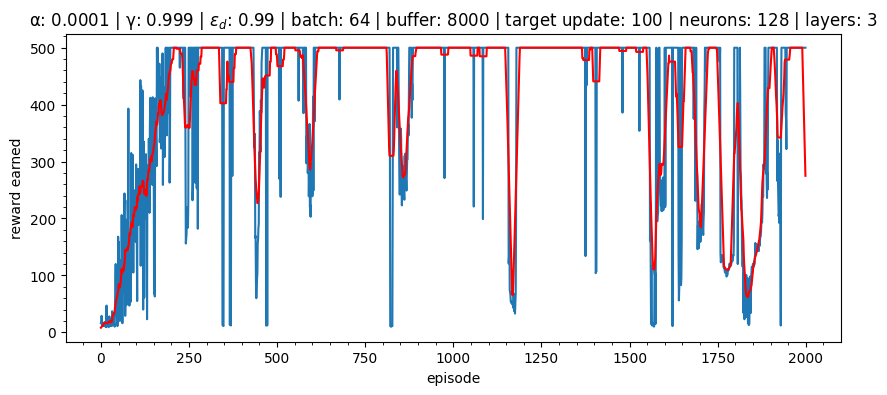

In [97]:
# moving average function:
def moving_average(interval, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(interval, window, 'same')

filtered_data = moving_average(reward_history, 20)

print(f"average reward was: {np.mean(filtered_data)}")

figure = plt.figure(figsize = (10, 4))
plt.plot(reward_history)
plt.plot(filtered_data, 'r-')
plt.minorticks_on()
plt.title(f"α: {lr} | γ: {gamma} | $ε_{"d"}$: {epsilon_decay} | batch: {batch_size} | buffer: {buffer_size} | target update: {target_update_freq} | neurons: {neurons} | layers: {layers}")
plt.xlabel('episode')
plt.ylabel('reward earned')

## **Visualization**

This section visualizes the performance of the trained agent.

In [98]:
visualize = True

if visualize:
    # prepare the new environment:
    env = gym.make("CartPole-v1", render_mode = 'human', max_episode_steps = 500)

    # wrap environment:
    # env = SwingUpWrapper(env)

    # give the agent the new environment:
    dqn_agent.env = env

    # prep the visualization:
    obs, _ = dqn_agent.env.reset()
    done = False

    # while false:
    while not done:
        # start rendering the environment:
        dqn_agent.env.render()

        # use Q-Network to determine the value of each action:
        q_values = dqn_agent.q_network.predict_on_batch(obs.reshape(1,-1))

        # pick the best action:
        action = tf.argmax(q_values[0]).numpy()

        # take the action on the environment:
        next_obs, reward, term, trunc, _ = dqn_agent.env.step(action)
        print(f"reward was: {reward}", end = "\r")

        # advance state:
        obs = next_obs

        # check the completion status:
        done = term or trunc

    env.close()

## **Save the Model**

This section saves the weights of the model, if the ``save_model`` flag is set.

In [100]:
# flag on whether or not to save the model:
save_model = True
if save_model:
    run_path = "weights/cartpole_optimized"
    os.makedirs(run_path, exist_ok = True)
    file_path = f"{run_path}/dqn_weights.weights.h5"

    # save the weights of the model:
    if save_model:
        dqn_agent.q_network.save_weights(file_path)
        print(f"model saved!")

model saved!
